In [1]:
import sys

import numpy as np
from scipy.stats import bernoulli
from math import log

import random
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Practical Session on Stochastic Linear Bandits :

The architecture of code below provides the environment to run a standard linear bandit experiment. 

## LinUCB : Implementing optimism in $R^d$

* Implement LinUCB as studied in class. In your opinion, what is (are) the bottleneck(s) of this algorithm ? 

**The LinUCB studied in class enable us to get a guaranteed maximal regret, as we choose the confidence interval. However, the bottleneck of the algorithm is that we need to compute the inverse of the covariance matrix each turn to do so.**

* One key step is to invert the covariance matrix in order to compute the elliptical norm of each available action. At round $t+1$ the new covariance matrix is very similar to the previous one... Can you think of a way to optimize this step by simply updating the old one ? 
Hint : You can search for a way to compute the inverse of the sum of an invertible matrix A and the outer product, $ uv^\top$, of vectors u and v.

**We can do this by using the Sherman–Morrison formula.**

$$(A + uv^\top)^{-1} = A^{-1} - \frac{A^{-1} uv^\top A^{-1}}{1+v^\top A^{-1}u}$$

**Using this we only inverse the covariance matrix at initialization of the algorithm and iteratively obtain the new inverse each turn, inducing less computing  complexity.**

* It is common practice to tweak LinUCB by multiplying the confidence bonus by some hyperparameter $ 0<\alpha <1 $. 
What would be the effect of doing so ? Do you think it is a good idea ? What are the risks ?

**This hyperparameter acts as a kind of learning paramater. It operates in the trade-off between exploration and explotation: the smaller this parameter gets, the more likely we'll exploit than explore (and vice versa).**  

**This could be a good idea in the sense that if we explore too much, we could never exploit in an efficient way the best strategies. But we have to choose this alpha carefully because we could end up exploiting a strategy that is not the optimal one if we don't explore enough.**

## LinTS : Taking the Bayesian way

Thompson Sampling is a popular bayesian alternative to the standard optimistic bandit algorithms (see Chapter 36 of Bandit Algorithms). The key idea is to rely on Bayesian samples to get a proxy for the hidden parameter $\theta$ of the problem instead of building high-probability confidence regions. 

* Let us place a Gaussian prior with mean $\mathbf{0}$ and covariance $\sigma_0 I$ on $\theta$. Given actions $A_1,\ldots,A_t$ and rewards $Y_1,\ldots,Y_t$, Can you compute the expression of the posterior at the beginning of round $t+1$ ? 
* Implement LinTS (Linear Thompson Sampling)

# Plot Function

In [2]:
## Plot function : 
#-*-coding: utf-8 -*-

current_palette = sns.color_palette()
sns.set_style("ticks")


styles = ['o', '^', 's', 'D', '*']
colors = current_palette[0:4]+current_palette[5:6]
color_lb = current_palette[4]

algos = {'LinUCB': 'LinUCB',
         'Unif': 'Unif'}

def plot_regret(data, tsav, filename, log=False, taum=False,
                freq=50, qtl=False):
    fig = plt.figure(figsize=(7, 6))
    Nsub = len(tsav)
    T = len(data[0][1]) # length of regret
    N_curves = len(data)
    if log == True:
        plt.xscale('log')
        markevery = 1. / 12
        freq = 1
    i = 0
    
    for key, regret, avgRegret, qRegret, QRegret in data:
        T = len(regret)
        if qtl:
            label = algos[key] # r"\textbf{%s}" % 
            plt.plot(tsav, avgRegret, marker=styles[i], markevery=4,
                     ms=10.0, label=label, color=colors[i])
            plt.fill_between(tsav, qRegret, QRegret, alpha=0.15, 
                             linewidth=1.5, color=colors[i])
        else:
            label = algos[key] #r"\textbf{%s}" % algos[key]
            plt.plot(np.arange(len(regret))[0::freq], regret[0::freq],
                     marker=styles[i], ms=10.0,
                     label=label, color=colors[i])
        i += 1

    plt.legend(loc=2)
    plt.xlabel('Round t', fontsize=20)
    plt.ylabel('Regret R(T)', fontsize=18)
        
    plt.savefig('%s.pdf' % (filename), bbox_inches='tight')
    plt.show()
    plt.close(fig)
    return
  
 


# Action generators 

In [3]:
def randomActionsGenerator(K,d):
    """
    K: int -- number of action vectors to be generated
    d : int -- dimension of the action space
    returns : an array of K vectors uniformly sampled on the unit sphere in R^d
    """

    vecs = np.random.multivariate_normal(np.zeros(d), np.eye(d), size =K)
    norms = np.linalg.norm(vecs,axis=1)
    return vecs / norms[:,np.newaxis]

In [4]:
a = randomActionsGenerator(100,2)

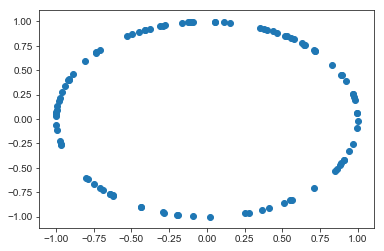

In [5]:
plt.scatter(a[:,0],a[:,1])

# Environment Class

In [6]:
class Environment:
    """
    Parameters:
    -----------
    K:  int
        Number of arms generated at each round

    d: int
        Dimension of the problem

    theta: d-dimensional vector
        Key hidden parameter of the problem


    """

    def __init__(self, d, K, theta):
        self.theta = theta
        self.d = d
        self.K = K




    def play(self, chosen_arm):
        """Play the arm with index choice and returns the corresponding reward:

            expected_reward + gaussian_noise
            """

        expected_reward = np.dot(chosen_arm, self.theta)
        reward = np.random.normal(expected_reward)

        return chosen_arm, expected_reward, reward

    def getBestArm(self, arms):
        """Return the index of the best arm and the corresponding expected payoff"""
        payoffs = np.zeros(self.K)
        for i in range(self.K):
            payoffs[i] = np.dot(arms[i,:], self.theta)

        bestArm = np.argmax(payoffs)
        return bestArm, payoffs[bestArm]

# Simulator

In [7]:
class Simulator():
    """
    Simulator of stochastic delayed games.

    Params:
    -------

    policies: list
        List of policies to test.

    K: int
        Number of arms to be generated at each round

    d: int
        Dimension of the problem

    """

    def __init__(self, environment, policies, K, d):
        self.env = environment
        self.policies = policies
        self.d = d
        self.K = K

    def run(self, T, N, q, tsav):
        """Runs an experiment with parameters T and N.

            It returns a dictionary whose keys are policies and whose values
            are the regret obtained by these policies over the experiments and
            averaged over N runs.qRegret and QRegret are the first and third quartiles.

            Parameters
            ----------
            T: int
                Length of the sequential allocations.

            N: int
                Number of Monte Carlo repetitions.

            q: int
                Quantile parameter (e.g. 25 -> quartiles)

            tsav: numpy array (ndim = 1)
                Points to save on each trajectory.
            """
        #Nsub = np.size(tsav)
        
        regret, cumRegret, N_plays = dict(), dict(), dict()
        Nsub = np.size(tsav)  # Number of points saved for each trajectory
        avgRegret, qRegret, QRegret = dict(), dict(), dict()

        for policy in self.policies:
            name = policy.id()
            cumRegret[name] = np.zeros((N, Nsub))
            regret[name] = np.zeros(T)

        for nExp in range(N):
            if N < 10 or nExp % (N / 5) == 0:
                print("experiments executed:", nExp)
                sys.stdout.flush()

            for policy in self.policies:

                name = policy.id()
                # Reinitialize the policy
                policy.init()
                optimalRewards = np.zeros(T)
                rewards = np.zeros(T)

                # We follow the policy
                #print "ready for experiment %d" % (nExp)
                for t in range(T):

                    # get arms, play one of them (policy), get reward:
                    availableArms = randomActionsGenerator(self.K,self.d)  
                    A_t = policy.selectArm(availableArms, self.K)
                    chosen_arm, expected_reward, reward = self.env.play(availableArms[A_t,:])

                    #update the policy:
                    policy.updateState(chosen_arm,reward)

                    #compute instant pseudo regret
                    instantBestArm, instantBestReward = self.env.getBestArm(availableArms)
                    optimalRewards[t] += instantBestReward
                    rewards[t] += expected_reward


                regret[name] += (optimalRewards - rewards) 
                cumRegret[name][nExp] += np.cumsum(optimalRewards - rewards)[tsav]


        print("build data out of the experiments")
        for policy in self.policies:
            name = policy.id()
            regret[name] = np.cumsum(regret[name]) / N

            cumReg = cumRegret[name]
            avgRegret[name] = np.mean(cumReg, 0)
            qRegret[name] = np.percentile(cumReg, q, 0)
            QRegret[name] = np.percentile(cumReg, 100 - q, 0)

        print("data built")
        return regret, avgRegret, qRegret, QRegret

# Policies

In [8]:
class Policy(object):

    def __init__(self, K, T):
        """
        Constructor.
        """
        raise NotImplementedError("Method `__init__` is not implemented.")

    def selectArm(self):
        """
        This functions selects L arms among the K ones depending on statistics
        over the past observations.
        """
        raise NotImplementedError("Method `selectArms` is not implemented.")

    def updateState(self):
        """
        This function updates the statistics given the new observations.
        """
        raise NotImplementedError("Method `updateState` is not implemented.")

    def init(self):
        """
        This function updates the statistics given the new observations.
        """
        raise NotImplementedError("Method `updateState` is not implemented.") 

    #@staticmethod
    def id(self):
        raise NotImplementedError("Static method `id` is not implemented.")

In [9]:
## Policies :

class Uniform(Policy):
    def __init__(self, T,d):
        pass
    
    def selectArm(self, arms, K):
        return np.random.choice(K)

    def updateState(self, chosen_arm, reward):
        pass

    def init(self):
        pass

    #@staticmethod
    def id(self):
        return 'Unif'

from numpy.linalg import pinv


class LinUCB(Policy):

    def __init__(self, T, d, delta, params):
        self.T = T
        self.d = d
        self.delta = delta
        self.lmbda = params['Lambda'] if 'Lambda' in params else 1 
        self.S = params['S'] if 'S' in params else 1
        self.alpha = params['Alpha'] if 'Alpha' in params else 1 
        self.params = params
        #dropping the loglog(t) term for now

    def init(self):
        self.t = 0
        self.theta = np.zeros(self.d)
        self.V = self.lmbda*np.identity(self.d)
        self.inv_V = np.linalg.inv(self.V)
        self.sum_AX = np.zeros(self.d)
        
    def selectArm(self, arms, K):
        """
        This function implements LinUCB
        Input:
        -------
        arms : list of arms (d-dimensional vectors)

        Output:
        -------
        chosen_arm : index of the pulled arm
        """
        
        beta = np.sqrt(self.lmbda)*self.S + np.sqrt(2*log(1/self.delta) + log(np.linalg.det(self.V) / (self.lmbda**self.d)))
        
        payoffs = [arm @ self.theta + np.sqrt(beta * self.alpha) *(arm.T @ self.inv_V @ arm)
                   for arm in arms]
        
        return np.argmax(payoffs)
    
    def updateState(self, chosen_arm, reward):
        self.V += np.outer(chosen_arm, chosen_arm)
        # With "naive LinUCB" implementation, simply use np.linalg.inv(self.V) for inverse of covariance matrix
        # Clever implementation below: using Sherman–Morrison formula
        self.inv_V -= (self.inv_V @ np.outer(chosen_arm, chosen_arm) @ self.inv_V) / (1 + chosen_arm.T @ self.inv_V @ chosen_arm)
        self.sum_AX += chosen_arm * reward
        self.theta = self.inv_V @ self.sum_AX
        pass
    
    def id(self):
        return "LinUCB"

# main

In [10]:
import time
import numpy as np
import pickle

d = 15  # dimension
K = 30  # number of arms

# parametor vector \theta, normalized :
theta = np.random.randint(2, size=d)
theta = theta / np.linalg.norm(theta)


T = 1000  # Finite Horizon
N = 10  # Monte Carlo simulations

delta = 0.1

# save subsampled points for Figures
Nsub = 100
tsav = range(2, T, Nsub)

#choice of quantile display
q = 10



def main(N):

    # Create an object of K arms with delayed feedback with mean delay tau
    env = Environment(d, K, theta)
    # Policies to evaluate
    policies = [LinUCB(T, d, delta, params={'Lambda': 1, 'S': 1, 'Alpha': 0.1}),
                Uniform(T,d)]

    simulator = Simulator(env, policies, K, d)

    regret, avgRegret, qRegret, QRegret= simulator.run(T, N, q, tsav)

    data = [[
      policy, regret[policy], avgRegret[policy], qRegret[policy],
      QRegret[policy]
    ] for policy in avgRegret]

    return data


data = main(N)
  
#data 
#   with open('linucb_test' + str(d) + '_dim-' + str(K) + '_K' + '.pkl',
#             'wb') as foutput:
#     pickle.dump(data, foutput, protocol=2)

experiments executed: 0
experiments executed: 2
experiments executed: 4
experiments executed: 6
experiments executed: 8
build data out of the experiments
data built


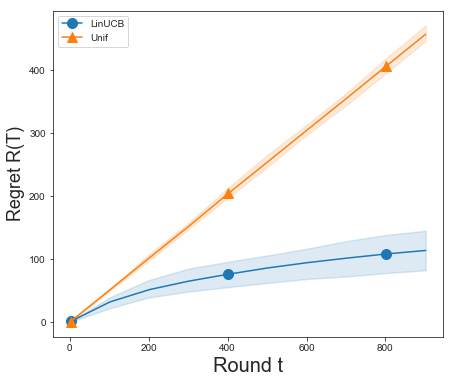

In [11]:
freq = 10
plot_regret(
    data,
    tsav,
    'linucb_test' + str(d) + '_dim-' + str(K) + '_K',
    log=False,
    freq=freq,
    qtl=True)